In [137]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import Lasso

In [138]:
# read the data
# df = pd.read_pickle('data/selected_data.pkl')
df = pd.read_pickle('data/selected_data.pkl')

# print the shape of the data 
print(f'Data contains {df.shape[0]} rows and {df.shape[1]} columns')

Data contains 83 rows and 62 columns


In [139]:
y_labels = ['gdp_growth']
X_labels = [col for col in df.columns if col not in y_labels+['constant']]


# define the data
X = df[X_labels].values
y = df[y_labels].values

# standardize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

# Define the number of samples and features
n = X.shape[0] # number of samples
p = df.shape[1] # number of features

In [176]:
class MyLasso_123:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def lasso(self, lambda_):
        """ """
        # Lasso regression
        lasso = Lasso(alpha=lambda_, max_iter=10_000,fit_intercept=False)
        fit = lasso.fit(self.X, self.y)
        return fit.coef_

In [201]:
x_chosen = X[:,:]
y_chosen = y[:]
# step 2: calculate beta_pilot = beta ( pilot_lambda)
class penalty_term:
    def __init__(self, X:np.ndarray, y:np.ndarray, alpha:float, c:float, n:int, p:int):
        self.n = n
        self.p = p
        self.X = X
        self.y = y
        self.alpha = alpha
        self.c = c
    
    def _max_term(self, func:callable, **kwargs):
        # calculate the max term
        max_term = {}
        for j in range(self.X.shape[1]):
            max_term[j] = func(self.X[:,j], **kwargs)
        return max(max_term.values())
    
    def _scale_factor(self, ):
        return 2*self.c/np.sqrt(self.n)
    
    def _quantile_factor(self, ):
        return norm.ppf(1-self.alpha/(2*p))

    def brt_rule(self, sigma:float):
        scale = self._scale_factor() * sigma
        quantile = self._quantile_factor()
        max_term = self._max_term(lambda x: np.sqrt(np.mean(x**2)))
        return scale*quantile*max_term
    def bcch_pilot_rule(self):
        scale = self._scale_factor()
        quantile = self._quantile_factor()
        max_term = self._max_term(func=(lambda x, y: np.sqrt(np.mean((y-y.mean())**2*x**2))), y=self.y)
        return scale*quantile*max_term
    def bcch_rule(self, residuals:np.ndarray):
        scale = self._scale_factor() # scale factor
        quantile = self._quantile_factor()
        max_term = self._max_term(func=(lambda x, y: np.sqrt(np.mean((y-y.mean())**2*x**2))), y=residuals)
        return scale*quantile*max_term

lasso_ = MyLasso_123(X=x_chosen, y=y_chosen)

print('BCCH \n','---'*10,)
print('Baby step')
penalty_term_obj = penalty_term(X=x_chosen, y=y_chosen, alpha=0.05, c=1.1, n=n, p=p)
p_lambda = penalty_term_obj.bcch_pilot_rule()
beta_pilot = lasso_.lasso(p_lambda)
print(f'We get a lambda={p_lambda:.4f}\n',beta_pilot,'\n', '---'*2)

# d
print('Grown up step')
residuals = y_chosen - x_chosen @ beta_pilot
bcch_lambda = penalty_term_obj.bcch_rule(residuals=residuals)


beta_bcch = lasso_.lasso(bcch_lambda)
print(f'We get a lambda={bcch_lambda:.4f}\n',beta_bcch)
# print(f'lambda: {bcch_lambda:.6f} \n bcch betas\n', beta_bcch)
print('---'*10,'\n'*2)
# try with BRT 

print('BRT \n','---'*10,)
brt_lambda = penalty_term_obj.brt_rule(sigma=0.1)
beta_brt = lasso_.lasso(brt_lambda)
print(f'We get a lambda={brt_lambda:.4f}\n',np.around(beta_brt,2))
print('---'*10,)



BCCH 
 ------------------------------
Baby step
We get a lambda=0.8091
 [-0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.] 
 ------
Grown up step
We get a lambda=0.8091
 [-0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.]
------------------------------ 


BRT 
 ------------------------------
We get a lambda=0.0809
 [-0.36 -0.   -0.   -0.   -0.    0.    0.06 -0.    0.    0.09 -0.   -0.
 -0.   -0.   -0.    0.01  0.23  0.   -0.    0.01 -0.    0.   -0.    0.
 -0.   -0.02  0.    0.   -0.    0.    0.11 -0.04 -0.04  0.    0.    0.08
  0.    0.    0.    0.   -0.   -0.   -0.   -0.    0.   -0.31 -0.    0.
 -0.27  0.

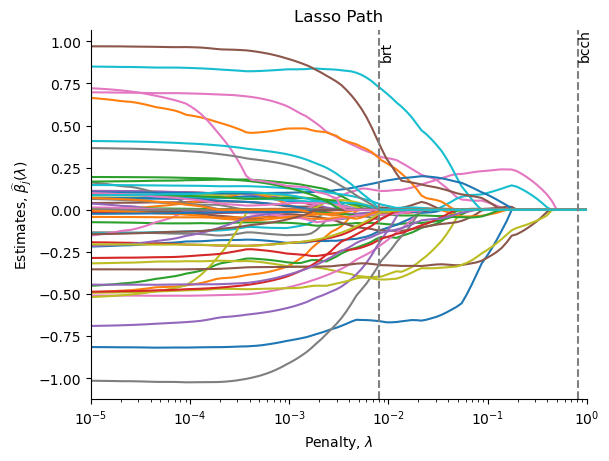

In [155]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legends
    # lgd=ax.legend(legends,loc=(1.04,0))

    # set x lim 
    ax.set_xlim([min(penalty_grid), max(penalty_grid)])
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,0.9,name,rotation=90)

    # Display plot
    plt.show()
    plt.close()

# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.00001,1,100)

coefs=[]
non_zeros = {}
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb, fit_intercept=False, max_iter=100_000).fit(x_chosen,y_chosen) 
    non_zeros[lamb] = [i for i in range(len(fit.coef_)) if fit.coef_[i] != 0]
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

# Plot lasso path
plot_lasso_path(penalty_grid, coefs, X_labels[:20], vlines={'brt':brt_lambda, 'bcch':bcch_lambda})

In [143]:
for key, value in non_zeros.items():
    non_zeros[key] = len(value)
non_zeros

{1e-08: 59,
 1.2129664476377577e-08: 59,
 1.4712876030949614e-08: 59,
 1.7846224973795665e-08: 60,
 2.1646872110209122e-08: 59,
 2.625692956598921e-08: 60,
 3.184877458153274e-08: 60,
 3.8631494965777486e-08: 59,
 4.685870721557504e-08: 60,
 5.683803963217383e-08: 59,
 6.894263502333197e-08: 60,
 8.362510309503727e-08: 59,
 1.0143444423452863e-07: 59,
 1.2303657749126642e-07: 60,
 1.4923924032908914e-07: 60,
 1.8102219119013285e-07: 59,
 2.1957384419149845e-07: 59,
 2.6633570578312836e-07: 60,
 3.2305627492285623e-07: 60,
 3.9185642218026297e-07: 60,
 4.753086923960351e-07: 59,
 5.765334961469663e-07: 60,
 6.993157867655627e-07: 59,
 8.482465856500283e-07: 60,
 1.0288946477167696e-06: 60,
 1.2480146858345123e-06: 59,
 1.5137999400764407e-06: 60,
 1.8361885357487709e-06: 59,
 2.2272350854003626e-06: 59,
 2.701561429592256e-06: 60,
 3.276903370327701e-06: 60,
 3.974773840358588e-06: 60,
 4.821267305303244e-06: 60,
 5.84803547642574e-06: 60,
 7.093470817499698e-06: 59,
 8.60414209892471e-